# Задание на программирование

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания. После того, как все ответы совпадут, можно будет использовать полученный блокнот для выполнения индивидуального задания.**

Зададим гиперпараметры модели

In [27]:
epsilon = 0.05 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.9 # Коэффциент дисконтирования гамма
random_seed = 10  #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [2]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [28]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFFFF
FFFFFH
FFHFFF
HFFFFF
FFFFFF
HFHFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [29]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
  Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2]) - Q[state, action])
  # Q[state, action] = (1 - lr_rate) * Q[state, action] + lr_rate * (reward + gamma * max_next_q)

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [31]:
from tqdm import tqdm

# Inititalization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

# Additional variables for tracking consecutive victories
consecutive_wins = 0
first_game_with_five_wins = 0
total_wins = 0

# Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    won_game = False  # Track if the agent won the current game

    while t < max_steps:
        t += 1

        action = choose_action(state)
        state2, reward, done, info = env.step(action)

        if t == max_steps:
            done = True

        learn(state, state2, reward, action, done)

        state = state2

        if done:
            if reward == 1:  # Agent won the game
                won_game = True
                consecutive_wins += 1
                total_wins += 1
                if consecutive_wins == 5:
                  print(game + 1)
                #first_game_with_five_wins = game - 4
            else:
                consecutive_wins = 0  # Reset consecutive wins



            break

print(' ')
print(f"Total number of wins out of {total_games} games: {total_wins}")
print(f"First game with five consecutive wins: {first_game_with_five_wins}")

  4%|▍         | 384/10000 [00:00<00:09, 1024.49it/s]

153
168
179
220
242
275


  6%|▋         | 649/10000 [00:00<00:07, 1192.47it/s]

446
547
571
579
627
704


  9%|▉         | 898/10000 [00:00<00:07, 1151.49it/s]

780
836


 13%|█▎        | 1317/10000 [00:01<00:06, 1324.02it/s]

1091
1175
1264


 16%|█▌        | 1585/10000 [00:01<00:06, 1295.75it/s]

1388
1409
1441
1515
1615
1628


 20%|██        | 2004/10000 [00:01<00:05, 1359.84it/s]

1821
1832
1925
2081


 23%|██▎       | 2275/10000 [00:01<00:05, 1327.59it/s]

2126
2148
2223
2246
2405


 27%|██▋       | 2704/10000 [00:02<00:05, 1389.69it/s]

2537
2617
2636


 31%|███▏      | 3138/10000 [00:02<00:04, 1411.71it/s]

2904
2913
2920
2946
3099
3108
3132


 34%|███▍      | 3423/10000 [00:02<00:04, 1417.17it/s]

3250
3317
3354
3411
3467
3504


 40%|███▉      | 3984/10000 [00:03<00:04, 1365.16it/s]

3722
3729
3754
3852


 44%|████▍     | 4409/10000 [00:03<00:04, 1375.87it/s]

4154
4174
4220
4292
4344


 48%|████▊     | 4820/10000 [00:03<00:03, 1339.02it/s]

4577
4778
4784
4844


 51%|█████     | 5093/10000 [00:03<00:03, 1318.05it/s]

4859
4881
4936
4951


 54%|█████▎    | 5364/10000 [00:04<00:03, 1332.19it/s]

5145
5160
5190
5229
5240
5258
5279
5341


 56%|█████▋    | 5638/10000 [00:04<00:03, 1347.64it/s]

5472
5520
5549
5560
5582
5594
5614
5620
5650
5711


 59%|█████▉    | 5917/10000 [00:04<00:03, 1312.59it/s]

5723
5772
5859


 62%|██████▏   | 6209/10000 [00:04<00:02, 1384.20it/s]

6066
6162
6172
6213
6282


 66%|██████▋   | 6632/10000 [00:05<00:02, 1375.20it/s]

6417
6468
6474
6548
6571
6590
6615
6655
6676


 69%|██████▉   | 6905/10000 [00:05<00:02, 1305.31it/s]

6719
6789
6817
6884
6895
6929


 72%|███████▏  | 7173/10000 [00:05<00:02, 1320.43it/s]

7013
7055
7085
7114
7134
7170
7181
7188


 74%|███████▍  | 7449/10000 [00:05<00:01, 1350.70it/s]

7285
7409
7416
7456


 77%|███████▋  | 7719/10000 [00:05<00:01, 1325.01it/s]

7575
7600
7718
7761
7793
7803
7816


 81%|████████▏ | 8136/10000 [00:06<00:01, 1365.61it/s]

7857
7892
7903
7927
7995
8014
8097


 84%|████████▍ | 8422/10000 [00:06<00:01, 1375.20it/s]

8210
8330
8384
8393
8429
8449


 87%|████████▋ | 8698/10000 [00:06<00:00, 1354.31it/s]

8513
8596
8608
8659
8683
8787


 90%|████████▉ | 8982/10000 [00:06<00:00, 1287.09it/s]

8799
8823
8847
8928
8965
8993


 93%|█████████▎| 9271/10000 [00:07<00:00, 1362.52it/s]

9037
9054
9159
9230
9284


 96%|█████████▌| 9555/10000 [00:07<00:00, 1391.22it/s]

9333
9412
9468
9499
9507
9533
9600


 98%|█████████▊| 9843/10000 [00:07<00:00, 1412.71it/s]

9619
9664
9720
9788
9796
9821


100%|██████████| 10000/10000 [00:07<00:00, 1317.43it/s]

9982
 
Total number of wins out of 10000 games: 9678
First game with five consecutive wins: 0


Вывод ответов при заданных параметрах

In [ ]:
print("Количество побед в серии из 10 000 игр: ", #ваш код здесь)
print("Пять побед подряд впервые было одержано в игре ", #ваш код здесь)

Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [34]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

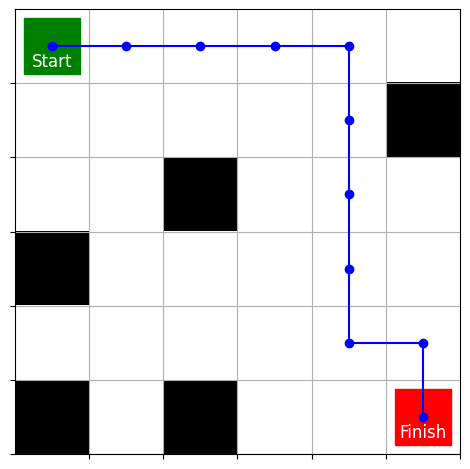

In [35]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")